<a href="https://colab.research.google.com/github/AlyAbdulloh/Machine-Learning-semester5/blob/main/JS10/JS10(RNN)_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I remember watching this in the 1970s - then I have just recently borrowed a couple of episodes from our public library.<br /><br />With a nearly 30 year hiatus, I have come to another conclusion. Most of the principals interviewed in this series - some at the center of power like Traudl Junge (Hitler\'s Secretary),Karl Doenitz (head of Germany\'s navy) Anthony Eden (UK) - are long gone but their first hand accounts will live on.From Generals and Admirals to Sergeants, Russian civilians, concentration camp survivors, all are on record here. <br /><br />I can remember the Lord Mountbatten interview (killed in the 1970s) <br /><br />This is truly a gem and I believe the producer of this series was knighted by Queen Elizabeth for this work - well deserved.<br /><br />Seeing these few episodes from the library makes me want to buy the set.<br /><br />This is the only "10" I have given any review but I have discovered like a fine bottle of wine, it is more appreciated with a litt

## Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 364, 147, ...,   0,   0,   0],
       [  1,   5,   2, ...,   0,   0,   0],
       [ 10,   1,  11, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I remember watching this in the 1970s - then I have just recently borrowed a couple of episodes from our public library.<br /><br />With a nearly 30 year hiatus, I have come to another conclusion. Most of the principals interviewed in this series - some at the center of power like Traudl Junge (Hitler\'s Secretary),Karl Doenitz (head of Germany\'s navy) Anthony Eden (UK) - are long gone but their first hand accounts will live on.From Generals and Admirals to Sergeants, Russian civilians, concentration camp survivors, all are on record here. <br /><br />I can remember the Lord Mountbatten interview (killed in the 1970s) <br /><br />This is truly a gem and I believe the producer of this series was knighted by Queen Elizabeth for this work - well deserved.<br /><br />Seeing these few episodes from the library makes me want to buy the set.<br /><br />This is the only "10" I have given any review but I have discovered like a fine bottle of wine, it is more appreciated with a li

## Buat Model

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00322998]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 320ms/step
[0.00322998]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [17]:
# history = model.fit(train_dataset, epochs=10,
#                     validation_data=test_dataset,
#                     validation_steps=30)

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    validation_steps=30,
    steps_per_epoch=10
)

Epoch 1/5
10/10 [==============================] - 25s 3s/step - loss: 0.3542 - accuracy: 0.8453 - val_loss: 0.3806 - val_accuracy: 0.8349
Epoch 2/5
10/10 [==============================] - 24s 2s/step - loss: 0.3526 - accuracy: 0.8453 - val_loss: 0.3983 - val_accuracy: 0.7958
Epoch 3/5
10/10 [==============================] - 24s 3s/step - loss: 0.3485 - accuracy: 0.8438 - val_loss: 0.3831 - val_accuracy: 0.8297
Epoch 4/5
10/10 [==============================] - 24s 3s/step - loss: 0.3920 - accuracy: 0.8250 - val_loss: 0.3790 - val_accuracy: 0.8250
Epoch 5/5
10/10 [==============================] - 32s 3s/step - loss: 0.3941 - accuracy: 0.8109 - val_loss: 0.3696 - val_accuracy: 0.8307


In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 136s 348ms/step - loss: 0.3548 - accuracy: 0.8364
Test Loss: 0.3547843396663666
Test Accuracy: 0.836359977722168


(0.0, 0.40081697702407837)

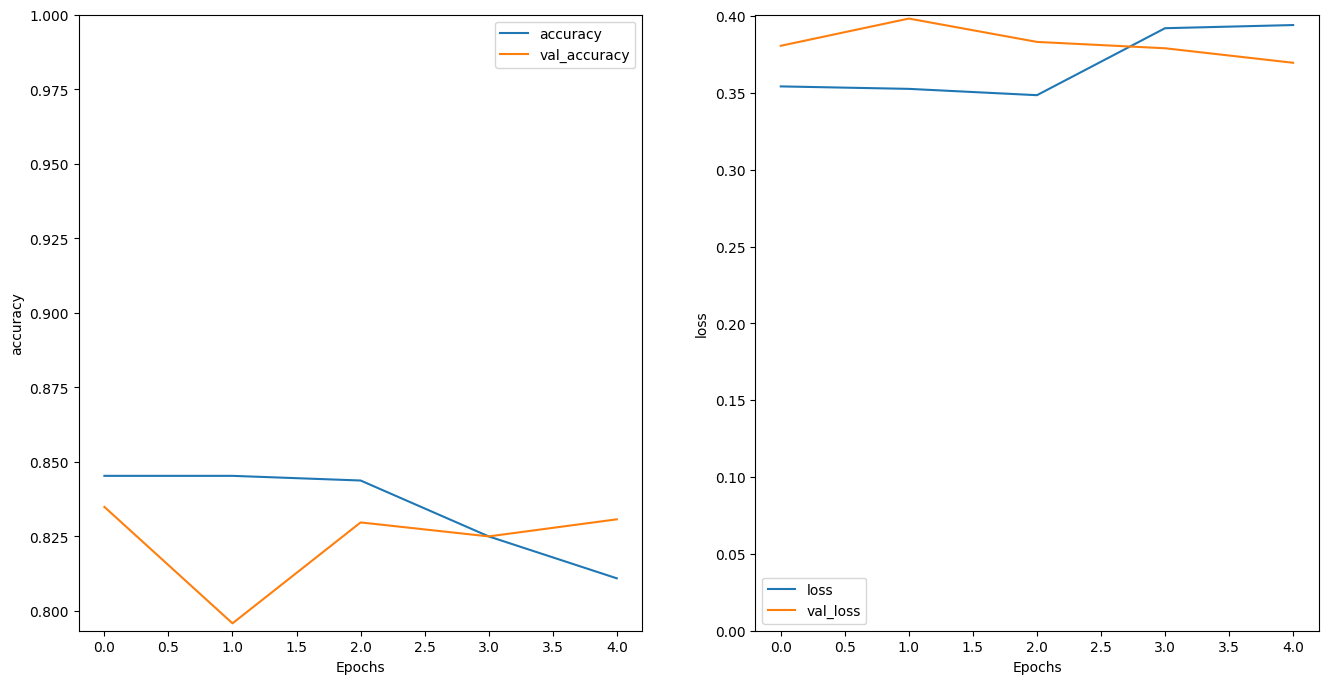

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


## Stack two or more LSTM layers

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
# history = model.fit(train_dataset, epochs=10,
#                     validation_data=test_dataset,
#                     validation_steps=30)
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    validation_steps=30,
    steps_per_epoch=10
)

Epoch 1/3
10/10 [==============================] - 60s 6s/step - loss: 0.6927 - accuracy: 0.5297 - val_loss: 0.6929 - val_accuracy: 0.4917
Epoch 2/3
10/10 [==============================] - 47s 5s/step - loss: 0.6925 - accuracy: 0.4969 - val_loss: 0.6928 - val_accuracy: 0.4917
Epoch 3/3
10/10 [==============================] - 47s 5s/step - loss: 0.6928 - accuracy: 0.4969 - val_loss: 0.6928 - val_accuracy: 0.4917


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 245s 627ms/step - loss: 0.6928 - accuracy: 0.5000
Test Loss: 0.6927943825721741
Test Accuracy: 0.5


In [27]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 10s 10s/step
[[0.00259073]]


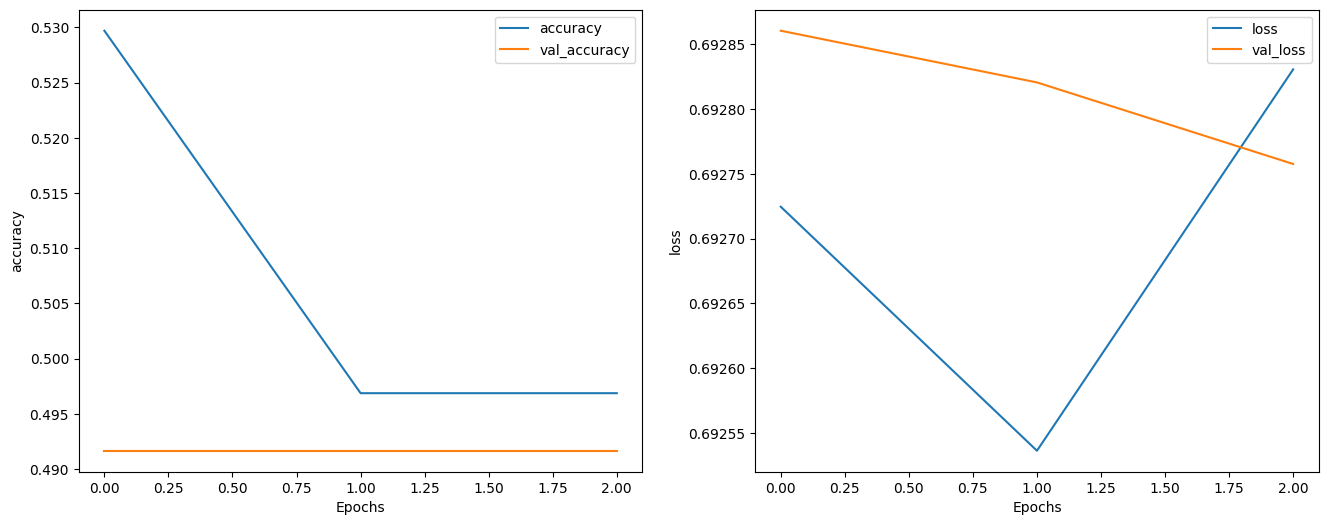

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')